# Word2Vec
### Model Architecture: CBOW

* Ran on Google Colabs

Torchtext Links:   
https://github.com/pytorch/text/tree/a5880a3da7928dd7dd529507eec943a307204de7/torchtext  

https://torchtext.readthedocs.io/en/latest/index.html

https://pytorch.org/docs/stable/data.html

https://www.fatalerrors.org/a/detailed-explanation-of-python-torch-text-field.html

## Import Libraries

In [ ]:
# !pip install -U torchtext==0.6.0

In [1]:
import torch
import torchtext
print(torch.__version__)
print(torchtext.__version__)

1.10.0+cu111
0.11.0


In [2]:
# Choosing device as Cuda if running on GPUotherwise using CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# Importing Libraries
import os
import json
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

from torch.utils.data import DataLoader

from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2, WikiText103, IMDB
from torchtext.legacy.data import Field, TabularDataset, BucketIterator

In [4]:
from functools import partial

def f(a, b, c, x):
    return 1000*a + 100*b + 10*c + x
  
g = partial(f, 1, 2, 3)
print(g(4))

1234


## Configurations

In [5]:
# Writing the major input parameters in the form f dictionary for the ease of use while initializing classes

HYPER_PARAMETERS = {
    # 'OPTIMIZER' :  optim.Adam()
    'LEARNING_RATE' :  0.025,
    'CRITERION' : nn.CrossEntropyLoss(),
    'EPOCHS' : 10,
}

MODEL_SAVINGS = {
    # 0 would mean dont save checkpoints
    'CHECKPOINT_FREQUENCY' : 1, 
    'DIRECTORY' : '/content',
    'DATA_DIRECTORY' : '',
    'MODEL_WEIGHTS_DIRECTORY' : '/Files/Model_Weights',
    'CHECKPOINT_DIRECTORY' : '/Files/Checkpoints',
    'LOSS_DIRECTORY' : '/Files/Loss'
}

SPLIT_TYPE = {
    'TRAIN_BATCH_SIZE': 96,
    'VAL_BATCH_SIZE' : 96,
    'TRAIN_STEPS' : None,
    'VAL_STEPS' : None,
}

CBOW_SPECS = {
    'MAX_SEQUENCE_LENGTH' : 256,
    'CBOW_N_WORDS' : 4,
    'MIN_WORD_FREQUENCY' : 30,
    'EMBED_DIMENSION' : 300,
    'EMBED_MAX_NORM' : 1
}

In [6]:
# if on google Colabs
dir = "/content"
files = os.listdir(dir)
files

# Otherwise

# dir = "/content"
# os.makedirs(dir)

['.config', 'Files', 'sample_data']

In [8]:
# Creating local directories for weights, checkpoints and losses
os.makedirs(dir + MODEL_SAVINGS['MODEL_WEIGHTS_DIRECTORY'])
os.makedirs(dir + MODEL_SAVINGS['CHECKPOINT_DIRECTORY'])
os.makedirs(dir + MODEL_SAVINGS['LOSS_DIRECTORY'])
os.listdir(dir)

['.config', 'Files', '.ipynb_checkpoints', 'sample_data']

## Data Preparation

In [9]:
# Making a class for the entire Data preprocessing stage from Data importing to creating Data Loaders
class Data_Preparation:
  def __init__(self, SPLIT_TYPE, CBOW_SPECS):

    self.SPLIT_TYPE = SPLIT_TYPE
    self.CBOW_SPECS = CBOW_SPECS
    print('Data Preparation is initialized!')

  def getTokenizer(self,):
    # Using PyTorch's tokenizer instead of custom or spacy's
    return get_tokenizer("basic_english", language="en")

  def getDataIterator(self, splitType = 'train'):
    # Getting Data in form of Data Iterators to feed to the Data Loaders

    # torchtext.data.datasets_utils._RawTextIterableDataset
    DATA_ITER = WikiText2(split=(splitType))
    # torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset
    DATA_ITER = to_map_style_dataset(DATA_ITER)
    return DATA_ITER

  def getVocab(self, dataIter):
    # Creating Vocab based on training data

    # Data Type: Vocab()
    tokenizer = self.getTokenizer()
    VOCAB = build_vocab_from_iterator(
        map(tokenizer, dataIter),
        specials=["<unk>"],
        min_freq=self.CBOW_SPECS['MIN_WORD_FREQUENCY']
    )
    # https://pytorch.org/text/stable/vocab.html
    # VOCAB.get_stoi() : Dictionary mapping tokens to indices.
    VOCAB.set_default_index(VOCAB["<unk>"])

    return VOCAB

  
  def collateCBOW(self, batch, text_pipeline):
    # Using CBOW as Word2Vec Algo
    # Context is represented as N=CBOW_N_WORDS past words and N=CBOW_N_WORDS future words.
    # Long paragraphs will be truncated to contain no more that MAX_SEQUENCE_LENGTH tokens.
    
    # contextWords is of length N=CBOW_N_WORDS*2 

    contextWords, middleWord = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        if len(text_tokens_ids) < CBOW_SPECS['CBOW_N_WORDS'] * 2 + 1:
            continue

        if CBOW_SPECS['MAX_SEQUENCE_LENGTH']:
            text_tokens_ids = text_tokens_ids[:CBOW_SPECS['MAX_SEQUENCE_LENGTH'] ]

        for idx in range(len(text_tokens_ids) -  CBOW_SPECS['CBOW_N_WORDS'] * 2):
            token_id_sequence = text_tokens_ids[idx : (idx +  CBOW_SPECS['CBOW_N_WORDS'] * 2 + 1)]
            output = token_id_sequence.pop(CBOW_SPECS['CBOW_N_WORDS'])
            input_ = token_id_sequence

            contextWords.append(input_)
            middleWord.append(output)

    contextWords = torch.tensor(contextWords, dtype=torch.long)
    middleWord = torch.tensor(middleWord, dtype=torch.long)
    return contextWords, middleWord
  

  def getDataLoader(self, dataIterator, textPipeline, splitType='train'):
    # Making DataLoaders for Train Data and Validation Data
    if splitType == 'train':
      batchSize = self.SPLIT_TYPE['VAL_BATCH_SIZE']
    elif splitType == 'valid':
      batchSize = self.SPLIT_TYPE['VAL_BATCH_SIZE']

    collate_fn = self.collateCBOW

    # torch.utils.data.dataloader.DataLoader
    dataLoaderObject = DataLoader(
        dataIterator,
        batch_size= batchSize,
        shuffle = True,
        collate_fn = partial(collate_fn, text_pipeline=textPipeline)
    )

    return dataLoaderObject

  def run(self,):
    # Main function to run all the processes sequentially from data importing to Data Loader objects

    tokenizer = self.getTokenizer()

    trainDataIterator = self.getDataIterator(splitType='train')
    valDataIterator = self.getDataIterator(splitType='valid')
    
    trainVocab = self.getVocab(trainDataIterator)
    valVocab = None
    # self.getVocab(valDataIterator)

    textPipeline = lambda x: trainVocab(tokenizer(x))

    trainDataLoader = self.getDataLoader(trainDataIterator, textPipeline, splitType='train') 
    ValDataLoader = self.getDataLoader(valDataIterator, textPipeline, splitType='valid')
    return trainDataLoader, ValDataLoader, trainVocab, valVocab


# Initialize Class Data Preparation
dataPrep = Data_Preparation(SPLIT_TYPE=SPLIT_TYPE, CBOW_SPECS=CBOW_SPECS)

Data Preparation is initialized!


In [10]:
trainDataLoader, ValDataLoader, trainVocab, _ = dataPrep.run()

In [11]:
vocabSize = len(trainVocab.get_stoi())
print(f"Vocabulary size: {vocabSize}")

Vocabulary size: 6093


In [12]:
LOADERS = [trainDataLoader, ValDataLoader]

In [13]:
for i, batch_data in enumerate(trainDataLoader,0):
  print(i, batch_data)
  break

0 (tensor([[   1, 6016,  433,  ..., 1744,  695,   21],
        [6016,  433,    2,  ...,  695,   21,    0],
        [ 433,    2,    1,  ...,   21,    0,   20],
        ...,
        [  77,    1, 4887,  ..., 1793,    0,    3],
        [   9,    9,    9,  ...,    9,    9,    9],
        [   9,    9,    9,  ...,    9,    9,    9]]), tensor([   1, 1565, 1744,  ...,    8, 3548,    0]))


## MODEL

In [14]:
# Initializing the CBOW Model and its forward feed
class CBOW_Model(nn.Module):

    def __init__(self, vocab_size: int, CBOW_SPECS):
        super(CBOW_Model, self).__init__()
      
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=CBOW_SPECS['EMBED_DIMENSION'],
            max_norm=CBOW_SPECS['EMBED_MAX_NORM']
        )
        self.linear = nn.Linear(
            in_features=CBOW_SPECS['EMBED_DIMENSION'],
            out_features=vocab_size,
        )

        print('CBOW Model initialized!')

    def forward(self, inputs_):
        x = self.embeddings(inputs_)
        x = x.mean(axis=1)
        x = self.linear(x)
        return x



model = CBOW_Model(vocab_size=vocabSize, CBOW_SPECS=CBOW_SPECS)

CBOW Model initialized!


## TRAINING MODEL

In [15]:
# Class created to take the model and train on the Data Loaders
class Train_Model:

  def __init__(self, model, HYPER_PARAMETERS, SPLIT_TYPE, CBOW_SPECS, MODEL_SAVINGS, LOADERS):
    self.model = model
    self.HYPER_PARAMETERS = HYPER_PARAMETERS
    self.SPLIT_TYPE = SPLIT_TYPE
    self.CBOW_SPECS = CBOW_SPECS
    self.MODEL_SAVINGS = MODEL_SAVINGS
    self.dir = self.MODEL_SAVINGS['DIRECTORY']

    self.trainLoader = LOADERS[0]
    self.valLoader = LOADERS[1]

    self.criterion = self.HYPER_PARAMETERS['CRITERION']
    self.optimizer = optim.Adam(self.model.parameters(), lr=self.HYPER_PARAMETERS['LEARNING_RATE'])
    self.loss = {"Train": [], "Val": []}
    self.lr_scheduler = None

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.model.to(self.device)

    print('Model Training Initialized!')

  def getLRScheduler(self, optimizer, total_epochs:int, verbose:bool=True):
    # Custom LR Scheduler
    # Scheduler to linearly decrease learning rate, so that learning rate after the last epoch is just a little > 0.
    lr_lambda = lambda epoch: ((total_epochs+1) - epoch) / total_epochs
    lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda, verbose=False)
    return lr_scheduler

  def _train_epoch(self,):
    # Training batches on training data loader
        self.model.train() # brings model into training stage
        running_loss = []

        # Training on batches of data
        for i, batch_data in enumerate(self.trainLoader, 1):
            inputs = batch_data[0].to(self.device)
            labels = batch_data[1].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.SPLIT_TYPE['TRAIN_STEPS']:
                break

        epoch_loss = np.mean(running_loss)
        self.loss["Train"].append(epoch_loss)
        
  def _validate_epoch(self):
    # Evaluating batches on validation data
        self.model.eval() # Brings model into eval stage
        running_loss = []

        with torch.no_grad(): # No gradients required here
            for i, batch_data in enumerate(self.valLoader, 1):
                inputs = batch_data[0].to(self.device)
                labels = batch_data[1].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.SPLIT_TYPE['VAL_STEPS']:
                    break

        epoch_loss = np.mean(running_loss)
        self.loss["Val"].append(epoch_loss)


  def train(self,):
    # Sequentially running the traing and evaluation on set number of epochs
    self.lr_scheduler = self.getLRScheduler(optimizer=self.optimizer, total_epochs=self.HYPER_PARAMETERS['EPOCHS'], verbose=True)
    for epoch in range(self.HYPER_PARAMETERS['EPOCHS']):
      # Calling training 
      self._train_epoch()
      # Calling validation
      self._validate_epoch()
      print(
          "Epoch: {}/{}, Train Loss={:.5f}, Val Loss={:.5f}".format(
              epoch + 1,
              self.HYPER_PARAMETERS['EPOCHS'],
              self.loss["Train"][-1],
              self.loss["Val"][-1],
          )
      )
      self.lr_scheduler.step()

      if self.MODEL_SAVINGS['CHECKPOINT_FREQUENCY']:
        self._save_checkpoint(epoch)
    print('Training Completed!')
  
  # Svaing checkpoints, model and losses
  def _save_checkpoint(self, epoch):
        
        epoch_num = epoch + 1
        if epoch_num % self.MODEL_SAVINGS['CHECKPOINT_FREQUENCY'] == 0:
            checkpoint_path = "checkpoint_epoch_#{}.pt".format(str(epoch_num).zfill(3))
            checkpoint_path = os.path.join(self.dir + self.MODEL_SAVINGS['CHECKPOINT_DIRECTORY'], checkpoint_path)
            torch.save(self.model, checkpoint_path)
            print('Saved checkpoint_{} to {}'.format(str(epoch_num), checkpoint_path) )
  def save_model(self):
        model_path = os.path.join(self.dir + self.MODEL_SAVINGS['MODEL_WEIGHTS_DIRECTORY'], "model.pt")
        torch.save(self.model, model_path)
        print('Saved model weights to {}'.format(model_path) )
  def save_loss(self):
      loss_path = os.path.join(self.dir + self.MODEL_SAVINGS['LOSS_DIRECTORY'], "loss.json")
      with open(loss_path, "w") as f:
          json.dump(self.loss, f)
      print('Saved loss to {}'.format(loss_path) )







trainModel = Train_Model(model, HYPER_PARAMETERS, SPLIT_TYPE, CBOW_SPECS, MODEL_SAVINGS, LOADERS)

Model Training Initialized!


In [16]:
trainModel.train()

Epoch: 1/10, Train Loss=5.72339, Val Loss=5.40377
Saved checkpoint_1 to /content/Files/Checkpoints/checkpoint_epoch_#001.pt
Epoch: 2/10, Train Loss=5.36830, Val Loss=5.25646
Saved checkpoint_2 to /content/Files/Checkpoints/checkpoint_epoch_#002.pt
Epoch: 3/10, Train Loss=5.24556, Val Loss=5.18830
Saved checkpoint_3 to /content/Files/Checkpoints/checkpoint_epoch_#003.pt
Epoch: 4/10, Train Loss=5.16469, Val Loss=5.15056
Saved checkpoint_4 to /content/Files/Checkpoints/checkpoint_epoch_#004.pt
Epoch: 5/10, Train Loss=5.10153, Val Loss=5.10289
Saved checkpoint_5 to /content/Files/Checkpoints/checkpoint_epoch_#005.pt
Epoch: 6/10, Train Loss=5.03811, Val Loss=5.06719
Saved checkpoint_6 to /content/Files/Checkpoints/checkpoint_epoch_#006.pt
Epoch: 7/10, Train Loss=4.97734, Val Loss=5.04299
Saved checkpoint_7 to /content/Files/Checkpoints/checkpoint_epoch_#007.pt
Epoch: 8/10, Train Loss=4.91009, Val Loss=4.99564
Saved checkpoint_8 to /content/Files/Checkpoints/checkpoint_epoch_#008.pt
Epoch: 9

### Save Model

In [17]:
trainModel.save_model()
trainModel.save_loss()

Saved model weights to /content/Files/Model_Weights/model.pt
Saved loss to /content/Files/Loss/loss.json


### Download to Local Computer

In [ ]:
# Download Files to Google Drive
!zip -r /content/file.zip /content/Files

In [ ]:
from google.colab import files
files.download("/content/file.zip")

### Visualize Losses

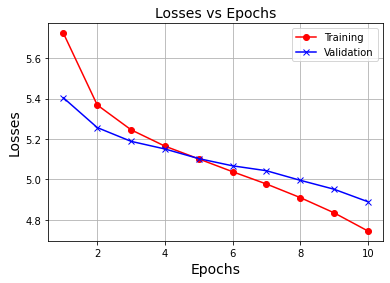

In [22]:
import numpy as np
import matplotlib.pyplot as plt

eps = list(np.arange(1,11))

plt.plot(eps, trainModel.loss['Train'], color='red', marker='o')
plt.plot(eps, trainModel.loss['Val'], color='blue', marker='x')
plt.title('Losses vs Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Losses', fontsize=14)
plt.grid(True)
plt.legend(['Training', 'Validation'])
plt.show()

### Getting Embeddings

In [23]:
import torch
import torch.nn as nn

import pandas as pd

from sklearn.manifold import TSNE
import plotly.graph_objects as go

In [24]:
embeddings = list(model.parameters())[0]
embeddings = embeddings.cpu().detach().numpy()

# Normalizing the embeddings
norms = (embeddings ** 2).sum(axis=1) ** (1 / 2)
norms = np.reshape(norms, (len(norms), 1))
embeddings_norm = embeddings / norms
embeddings_norm.shape

(6093, 300)

### Visualization with TSNE

In [25]:
# get embeddings
embeddings_df = pd.DataFrame(embeddings)

# t-SNE transform to visualize
tsne = TSNE(n_components=2)
embeddings_df_trans = tsne.fit_transform(embeddings_df)
embeddings_df_trans = pd.DataFrame(embeddings_df_trans)

# get token order
embeddings_df_trans.index = trainVocab.get_itos()

# if token is a number
is_numeric = embeddings_df_trans.index.str.isnumeric()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [26]:
color = np.where(is_numeric, "green", "black")
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=embeddings_df_trans[0],
        y=embeddings_df_trans[1],
        mode="text",
        text=embeddings_df_trans.index,
        textposition="middle center",
        textfont=dict(color=color),
    )
)
fig.write_html('/content/Files/word2vec_visualization.html')

In [2]:
fig.show()
# To View this TSNE Projection of Embeddings in 2D
# See the .html file attached

### Get Similar Words

In [28]:
# Getting most similar word embedding given a certain word
def get_top_similar(word: str, topN: int = 10):
    word_id = trainVocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = embeddings_norm[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))
    dists = np.matmul(embeddings_norm, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = trainVocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]
    return topN_dict

In [29]:
for word, sim in get_top_similar("holiday").items():
    print("{}: {:.3f}".format(word, sim))

christmas: 0.370
25th: 0.357
finale: 0.357
2009: 0.356
sample: 0.354
collaboration: 0.354
duet: 0.344
third: 0.342
documentary: 0.341
mix: 0.335


### Technique Details

To start off we used PyTorch to implement the Word2Vec. We used torchtext to import the WikiText 2 which consists of 36k text lines and 2M tokens in train part (tokens are words + punctuation). This corpus provided us with a vocab size of 6093 on the training data. In the original paper the corpus used for training was 6B words on the Google News corpus. Due to lack of resources we decided to use this dataset wehich could easily run 10 epochs in under 30 minutes with Google Colab's GPU's. The architecture we adopted was that of CBOW (Continuous Bag of Words) whose images are added below to drive the concept of the concept of how CBOW works. We ran our training and validation for 10 epochs with a dymnamic learning rate scheduler which decreased from 0.025 to close to 0 as the number of epochs increased. We used the Adam optimmizer compared to the Adagrad optimizer used in the paper and chose Cross Entropy as our Loss Function. Finally after we trained our embeddings we visualize the loss of traing compared to the validation and then projected the 300 dimensional word embedding to 2 dimension using T-distributed Stochastic Neighbourhood Embedding (tSNE)

### Experimental Validation, Insights and Discussion of Results

From the results we can see the similar word embeddings for the word `holiday`. The first 2 similar words embeddings give accurate similar words but after that we can see words which aren't too similar. One reason for this as we can see is that the 
number of words in the Vocabulary are very small 6093. So we'd need to train on a much larger corpus to see meaningful results.
Another reason maybe is our similarity function may not be the best and we can also test the similarity using cosine similarity.

Furthermore, on a dataset so small we can see that our CBOW model did't perform too bad and what we could have also done is trained a Skip-gram Model and compared both models and their similarity of embedding results.

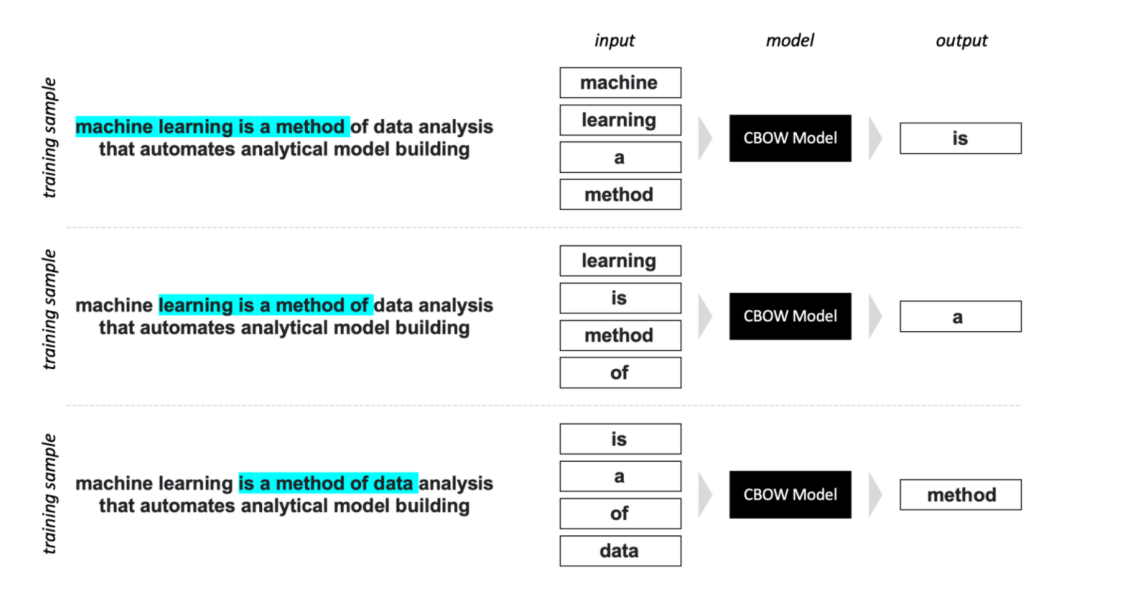

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def showImage(x):    
    plt.figure(figsize=(20,12))
    img = mpimg.imread(x + '.PNG')
    plt.imshow(img)
    plt.axis(False)
showImage('CBOW')

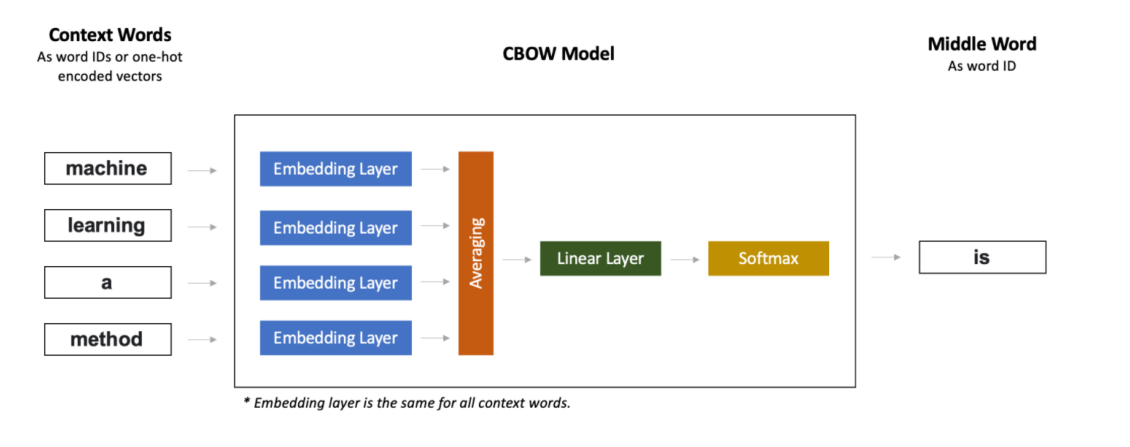

In [8]:
showImage('CBOW2')

### Load Model

In [ ]:
modelPath = os.path.join(MODEL_SAVINGS['DIRECTORY'] + MODEL_SAVINGS['MODEL_WEIGHTS_DIRECTORY'],'model.pt')
modelPath

In [ ]:
load_model = torch.load(modelPath)